# Analisis exploratorio de las variables en relación a los Spoilers en comentarios de IMDB

## 1. Procesamiento de datos

In [1]:
# Importamos las librerias generales para el proyecto
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings; warnings.simplefilter('ignore')
import seaborn as sns

from collections import Counter

import string

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
import seaborn as sns

In [2]:
# Lectura de los datos iniciales
movies_details = pd.read_json("./data/IMDB_movie_details.json", lines=True)
movies_reviews = pd.read_json("./data/IMDB_reviews.json", lines=True)
movies_info = pd.read_csv('./data/IMDb movies.csv')

In [3]:
# Eliminamos columnas inncesarias o repetidas para hacer 
movies_details_pre = movies_details[['movie_id', 'rating','release_date']]
movies_info_pre = movies_info[['imdb_title_id', 'original_title',
       'genre', 'duration', 'country', 'language', 'director', 'writer',
       'production_company', 'actors', 'votes',
       'budget', 'usa_gross_income', 'worlwide_gross_income', 'metascore',
       'reviews_from_users', 'reviews_from_critics']]

In [4]:
# Esta es una función para convertir diferentes tipos de moneda a dólares americanos

# Input: (String, Number) Un String que representa la mondeda (e.g., 'EUR') y el monto
# Output: (Number/None) Valor en dólares resultante / None si el valor era NaN
def convert_to_usd(currency, amount):
    if pd.isna(currency):
        return None
    rates = {'$': 1,'GBP': 0.76, 'FRF': 5.826, 'DEM': 1.733, 'CAD': 1.29, 'RUR': 73.77, 'EUR': 1.13, 'IEP': 0.665779, 'JPY': 113.74, 'TRL': 14.39, 'INR': 76.11, 'KRW': 1185.26, 'AUD': 1.41, 'BRL': 5.68}
    return amount / rates[currency]

In [5]:
# Combinamos los datasets para tener los datos completos
movies_data = movies_details_pre.merge(movies_info_pre, right_on="imdb_title_id", left_on="movie_id")

# Corregimos errores de repetición y de formato de los valores
movies_data = movies_data.drop(columns=["imdb_title_id"])
movies_data["currency"] = movies_data["budget"].str.split(" ", n = 1, expand = True)[0]
movies_data["budget"] = movies_data["budget"].str.split(" ", n = 1, expand = True)[1]
movies_data["budget"] = movies_data["budget"].astype('float64')
movies_data['budget'] = movies_data.apply(lambda p: convert_to_usd(p.currency, p.budget), axis=1)
movies_data = movies_data.drop(columns=["currency"])
movies_data["usa_gross_income"] = movies_data["usa_gross_income"].str.split(" ", n = 1, expand = True)[1]
movies_data["usa_gross_income"] = movies_data["usa_gross_income"].astype('float64')
movies_data["worlwide_gross_income"] = movies_data["worlwide_gross_income"].str.split(" ", n = 1, expand = True)[1]
movies_data["worlwide_gross_income"] = movies_data["worlwide_gross_income"].astype('float64')
movies_data["genre"] = movies_data.genre.apply(lambda x: x.split(', '))
movies_data["language"] = movies_data.language.apply(lambda x: x.split(', '))
movies_data["actors"] = movies_data.actors.apply(lambda x: x.split(', '))
movies_data["country"] = movies_data.country.apply(lambda x: x.split(', '))
movies_data["director"] = movies_data.director.apply(lambda x: x.split(', '))
movies_data["writer"] = movies_data.writer.apply(lambda x: x.split(', '))
movies_data['release_date'] = pd.to_datetime(movies_data['release_date'],format= '%Y-%m-%d' )

In [6]:
# Revisamos la existencia de valores NaN en las distintas columnas
movies_data.isnull().any()

movie_id                 False
rating                   False
release_date             False
original_title           False
genre                    False
duration                 False
country                  False
language                 False
director                 False
writer                   False
production_company       False
actors                   False
votes                    False
budget                    True
usa_gross_income          True
worlwide_gross_income     True
metascore                 True
reviews_from_users        True
reviews_from_critics     False
dtype: bool

In [7]:
# Comprobamos la forma de los datos para rellenar los valores NaN
movies_data.describe()

,rating,duration,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics
count,1534.000000,1534.000000,1.534000e+03,1.436000e+03,1.476000e+03,1.517000e+03,1431.000000,1533.000000,1534.000000
mean,7.049022,116.722947,2.647611e+05,5.453821e+07,9.017659e+07,2.018458e+08,62.636618,658.522505,224.512386
std,0.956515,22.759115,2.682681e+05,5.475451e+07,9.706665e+07,2.561669e+08,17.657524,676.416985,162.416418
min,2.400000,67.000000,1.413000e+03,6.000000e+00,5.090000e+02,5.760000e+02,9.000000,5.000000,1.000000
25%,6.400000,101.000000,9.080425e+04,1.500000e+07,2.556240e+07,3.528179e+07,50.000000,256.000000,106.250000
50%,7.100000,113.000000,1.863885e+05,3.500000e+07,5.840391e+07,1.159009e+08,63.000000,468.000000,178.000000
75%,7.800000,128.000000,3.455498e+05,7.525000e+07,1.242690e+08,2.647710e+08,75.000000,828.000000,311.750000
max,9.500000,321.000000,2.278845e+06,3.170000e+08,9.366622e+08,2.790439e+09,100.000000,8232.000000,999.000000


In [8]:
# Rellenamos los valores con la mediana para que no se vean afectados por los "outliers" y comprobamos nuevamente
movies_data = movies_data.fillna(movies_data.median())
movies_data.isnull().any()

movie_id                 False
rating                   False
release_date             False
original_title           False
genre                    False
duration                 False
country                  False
language                 False
director                 False
writer                   False
production_company       False
actors                   False
votes                    False
budget                   False
usa_gross_income         False
worlwide_gross_income    False
metascore                False
reviews_from_users       False
reviews_from_critics     False
dtype: bool

In [9]:
# Comprobamos valores NaN en los datos de las reviews
movies_reviews.isnull().any()

review_date       False
movie_id          False
user_id           False
is_spoiler        False
review_text       False
rating            False
review_summary    False
dtype: bool

In [10]:
# Creamos el dataframe con la proporcion de spoilers para cada pelicula
total_movies_reviews = pd.DataFrame(movies_reviews.groupby(by="movie_id").count()["is_spoiler"])
spoiler_movies_reviews = pd.DataFrame(movies_reviews[movies_reviews["is_spoiler"]==True].groupby(by="movie_id").count()["is_spoiler"])
reviews_data = spoiler_movies_reviews.merge(total_movies_reviews, right_index=True, left_index=True)
reviews_data.rename(columns={"is_spoiler_y":"total_reviews", "is_spoiler_x": "spoiler_reviews"}, inplace=True)
reviews_data["proportional"] = reviews_data["spoiler_reviews"] / reviews_data["total_reviews"]

# Juntamos con el anterior dataset que teniamos para tener el final
final_movies_data = movies_data.merge(reviews_data, right_index=True, left_on="movie_id")
final_movies_data.head(2)

,movie_id,rating,release_date,original_title,genre,duration,country,language,director,writer,...,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics,spoiler_reviews,total_reviews,proportional
0,tt0105112,6.9,1992-06-05,Patriot Games,"[Action, Thriller]",117,[USA],[English],[Phillip Noyce],"[Tom Clancy, W. Peter Iliff]",...,100936,45000000.0,83351587.0,178051587.0,64.0,154.0,62.0,17,100,0.170000
1,tt1204975,6.6,2013-11-01,Last Vegas,"[Comedy, Drama]",105,[USA],[English],[Jon Turteltaub],[Dan Fogelman],...,126219,28000000.0,63914167.0,134409025.0,48.0,201.0,229.0,50,157,0.318471


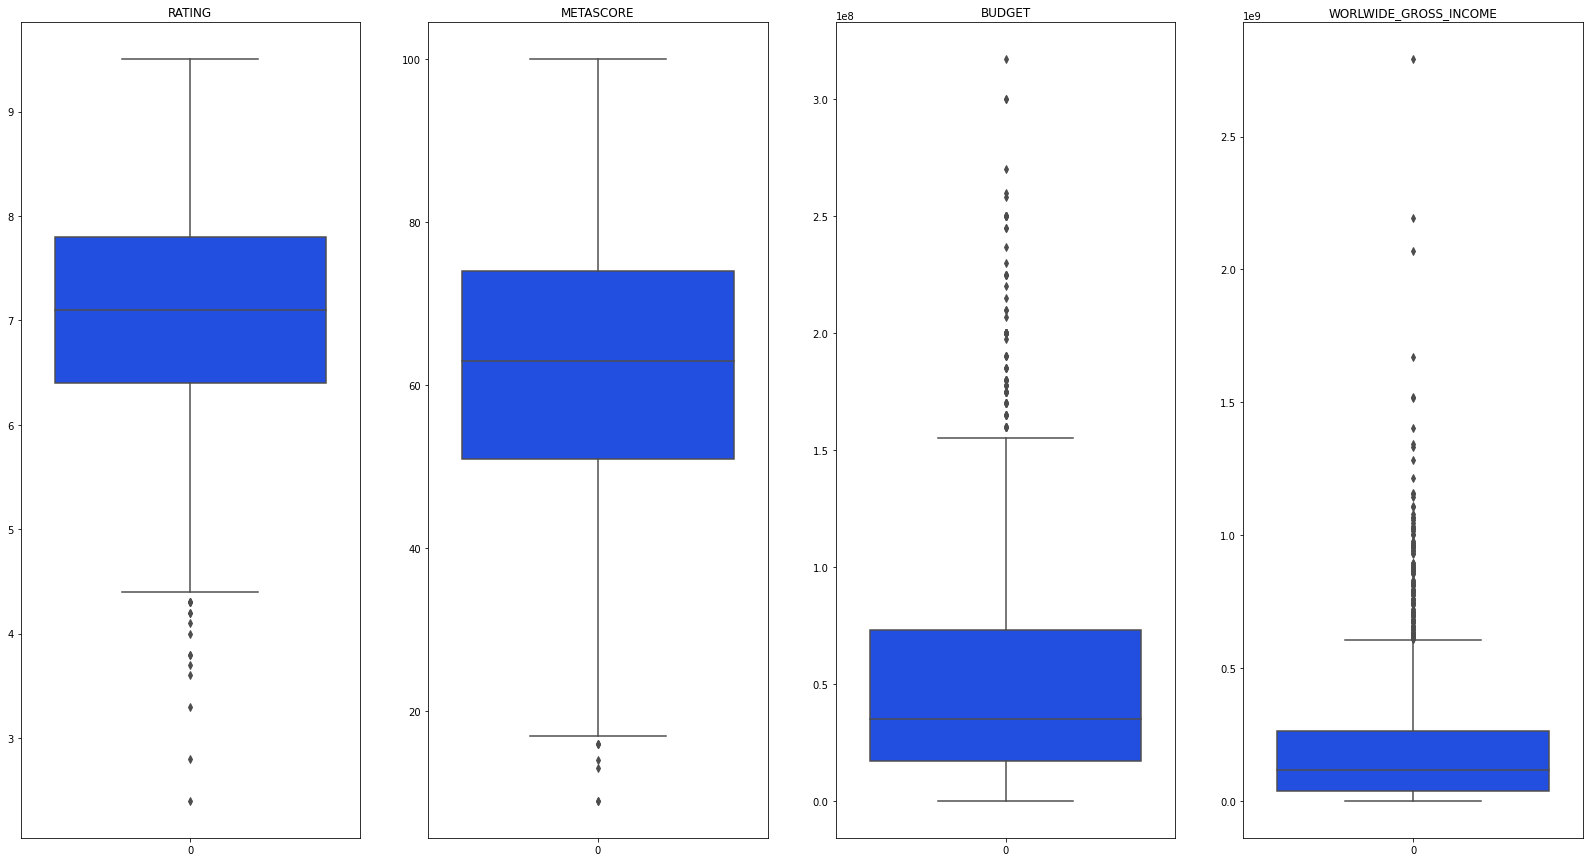

In [11]:
# Graficamos los outliers de las variables que más nos interesen
data = ['rating', 'metascore', 'budget', 'worlwide_gross_income']
fig, ax = plt.subplots(1,4,figsize= (28,15))

for i in range(len(data)):
    sns.boxplot(ax=ax[i], data=final_movies_data[data[i]], palette="bright").set_title(data[i].upper())

Podemos observar que en las distintas variables que analizamos existen varios outliers, en el caso de los ratings se aprecia que la mediana ronda un valor de 7/10 y un rango de valores comùnes entre 4.3/10 y 9.5/10, en base a este feature podemos observar outliers representados en puntos menores al lìmite menor previamente dicho.

En el caso del feature "metascore", podemos observar que la mediana es de 65 aproximadamente, mientras que sus rangos de valores comúnes ronda entre 18 y 100. Al igual 
que en el caso de ratings podemos observar outliers debajo del lìmite inferior comentado.

Al observar el feature "budget" podemos ver que contamos con considerablemente más outliers que los anteriores features. Indicando la gran brecha que existe entre el presupuesto invertido en cada película. La mediana del presupuesto es aproximadamente 4 millones de dolares y el rango de valores comúnes ronda entre 2 y 7 millones.

Finalmente, el "worlwide_gross_income" refleja algo parecido al "budget", donde se pueden observar ingresos excesivamente grandes comparados con los ingresos standard, siendo estos los outliers. La mediana del de los ingresos mundiales es aproximadamente 2 millones de dolares y el rango de valores comúnes ronda entre medio millon y 3 millones.

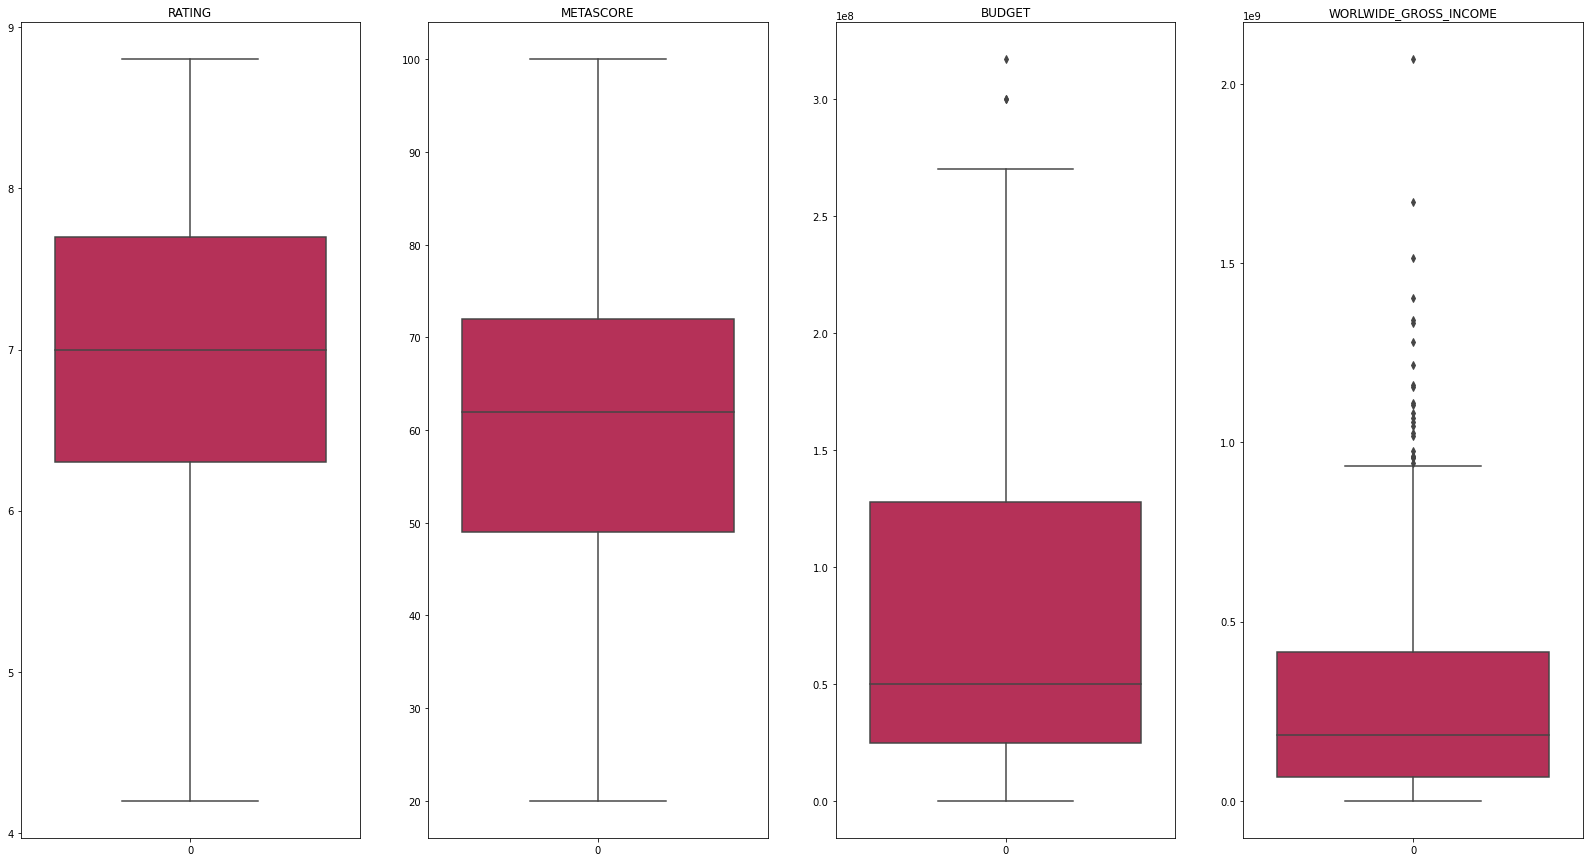

In [12]:
# Comparamos el gráfico anterior con los datos solo de las peliculas con mayor proporción de spoilers
final_movies_spoiler = final_movies_data[final_movies_data["proportional"] > final_movies_data["proportional"].quantile(q=0.75)].reset_index(drop=True)
fig, ax = plt.subplots(1,4,figsize= (28,15))

for i in range(len(data)):
    sns.boxplot(ax=ax[i], data=final_movies_spoiler[data[i]], palette="rocket").set_title(data[i].upper())

En comparación con el anterior gráfico mostrado, se pueden observar rangos de valores similares. Sin embargo se aprecia una disminución drastica de la cantidad de outliers en practicamente todos los features presentados.

In [13]:
# Obtenemos los coeficientes de relación entre los distintos features
final_movies_data.corr(method ='pearson')

,rating,duration,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics,spoiler_reviews,total_reviews,proportional
rating,1.000000,0.362784,0.519673,-0.114417,0.075141,0.076951,0.695529,0.319918,0.253759,0.236652,0.309142,0.006895
duration,0.362784,1.000000,0.325580,0.233352,0.193519,0.234550,0.232941,0.335113,0.218105,0.265450,0.303235,0.066053
votes,0.519673,0.325580,1.000000,0.296661,0.512981,0.512205,0.360032,0.757729,0.506690,0.635335,0.712126,0.176466
budget,-0.114417,0.233352,0.296661,1.000000,0.651887,0.725559,-0.141208,0.361821,0.435849,0.422683,0.334377,0.270524
usa_gross_income,0.075141,0.193519,0.512981,0.651887,1.000000,0.935139,0.075363,0.493901,0.435916,0.434226,0.380393,0.215518
worlwide_gross_income,0.076951,0.234550,0.512205,0.725559,0.935139,1.000000,0.057381,0.489802,0.488340,0.462906,0.391915,0.264178
metascore,0.695529,0.232941,0.360032,-0.141208,0.075363,0.057381,1.000000,0.234681,0.277715,0.180644,0.217015,0.031920
reviews_from_users,0.319918,0.335113,0.757729,0.361821,0.493901,0.489802,0.234681,1.000000,0.507046,0.695972,0.782183,0.153879
reviews_from_critics,0.253759,0.218105,0.506690,0.435849,0.435916,0.488340,0.277715,0.507046,1.000000,0.660274,0.524940,0.503294
spoiler_reviews,0.236652,0.265450,0.635335,0.422683,0.434226,0.462906,0.180644,0.695972,0.660274,1.000000,0.884318,0.573279


Haciendo un análisis entre la correlación de variables, notamos que no existen fuertes dependencias entre las variables escogidas, sin embargo, podemos destacar que las variables de budget, worldwide_gross y usa_gross tienen cierto grado de relación entre ellas. Por otro lado se puede observar una cierta relación entre reviews_from_critics con reviews_from_users y spoiler_reviews.

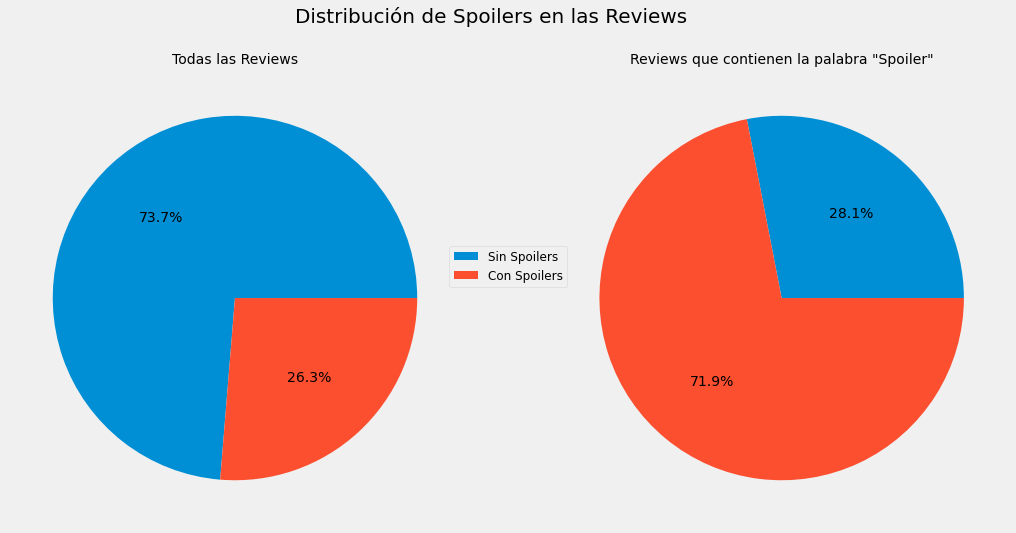

In [14]:
# Creamos un dataset para observar los spoilers en las reviews y las reviews que tienen la palabra 'spoiler'
reviews_spoiler = pd.DataFrame()
reviews_spoiler['is_spoiler'] = movies_reviews['is_spoiler']
reviews_spoiler['has_word_spoiler'] = movies_reviews['review_text'].apply(lambda text: 1 if 'spoiler' in text.lower() else 0)

# Separamos los datos para crear piecharts individuales
pie1 = reviews_spoiler['is_spoiler'].value_counts().reset_index().sort_values(by='index')
pie2 = reviews_spoiler[reviews_spoiler['has_word_spoiler'] == 1]['is_spoiler'].value_counts().reset_index().sort_values(by='index')

with plt.style.context('fivethirtyeight'):
    fig = plt.figure(figsize=(16, 8))

    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)

    ax1.pie(pie1['is_spoiler'], autopct="%.1f%%")
    ax1.set_title('Todas las Reviews', fontsize=14)

    ax2.pie(pie2['is_spoiler'], autopct="%.1f%%")
    ax2.set_title('Reviews que contienen la palabra "Spoiler"', fontsize=14)

    plt.suptitle('Distribución de Spoilers en las Reviews', fontsize=20)
    fig.legend(labels=['Sin Spoilers', 'Con Spoilers'], loc='center', fontsize=12)

    plt.show()

Podemos observar que de 573913 reviews analizados, el 26.3% contienen spoilers, indicando que la mayor parte de reviews estan libres de spoilers.

Además como curiosidad podemos ver que de las reviews que contienen la palabra 'spoiler', el 71.9% si contiene un verdadero spoiler. Esto podria indicar que la mayor parte de personas da un pequeño aviso para los demás lectores al momento de dar un spoiler, el otro porcentaje probablemente se esta quejando de los spoilers de otras personasmovies_reviews.

<AxesSubplot:title={'center':'Spoilers a lo largo del tiempo'}, xlabel='release_date'>

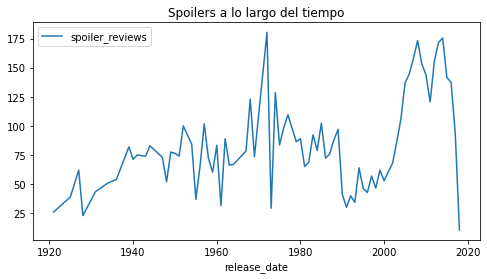

In [15]:
# Vemos como fueron produciéndose los spoilers a lo largo del tiempo
final_movies_data[['release_date','spoiler_reviews']].groupby(final_movies_data.release_date.dt.year).mean()\
                                .plot(figsize= (8,4),title="Spoilers a lo largo del tiempo")

Vemos que la cantidad de reseñas con spoilers a lo largo del tiempo fue incrementando hasta que 1970 tuvo su pico más alto y luego fueron reduciendo en cantidad. Sin embargo, a comienzos del siglo XX, las reseñas con spoilers comenzaron a popularizarse nuevamente.

Text(0.5, 0, 'Rating')

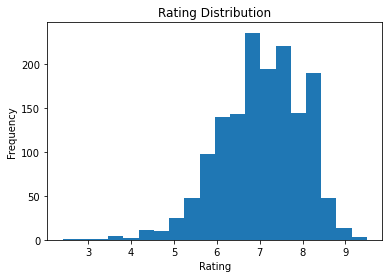

In [16]:
# Observamos la distribución de los ratings entre las películas
final_movies_data['rating'].plot(kind='hist',bins=20, title="Rating Distribution").set_xlabel("Rating")

Observamos una distribución aparentemente normal en los datos, lo cual es muy útil ya que nos da a conocer que tenemos un dataset variado. Tambien notamos un left skew en los datos, viendo que la gran mayoría de las películas fueron calificadas con un rating entre 6.5 y 7.5 aproximadamente.

In [17]:
# Realizamos un subasamplig por motivos de tiempo
movies_reviews_sample = movies_reviews[:200000].copy()

In [18]:
# Removemos signos de puntuación
movies_reviews_sample["review_text"] = movies_reviews_sample["review_text"].apply(lambda x: ''.join(ch for ch in x if ch not in string.punctuation).lower())

In [19]:
%%time
# Eliminamos palabras de enlace
nltk_stopwords = stopwords.words('english')
movies_reviews_sample["review_text"] = movies_reviews_sample["review_text"].apply(lambda x: (" ").join([word for word in word_tokenize(x) if not word in nltk_stopwords]))

Wall time: 3min 43s


In [20]:
# Contamos la cantidad de veces que se repiten las palabras en las reviews que contienen spoilers
counter_root = Counter()
movies_reviews_spoiler = movies_reviews_sample[movies_reviews_sample["is_spoiler"] == True].reset_index(drop=True)
movies_reviews_spoiler.review_text.apply(lambda x: counter_root.update(Counter(x.lower().split(" "))))

0        None
1        None
2        None
3        None
4        None
         ... 
57955    None
57956    None
57957    None
57958    None
57959    None
Name: review_text, Length: 57960, dtype: object

Text(0.5, 1.0, 'Palabras más repetidas')

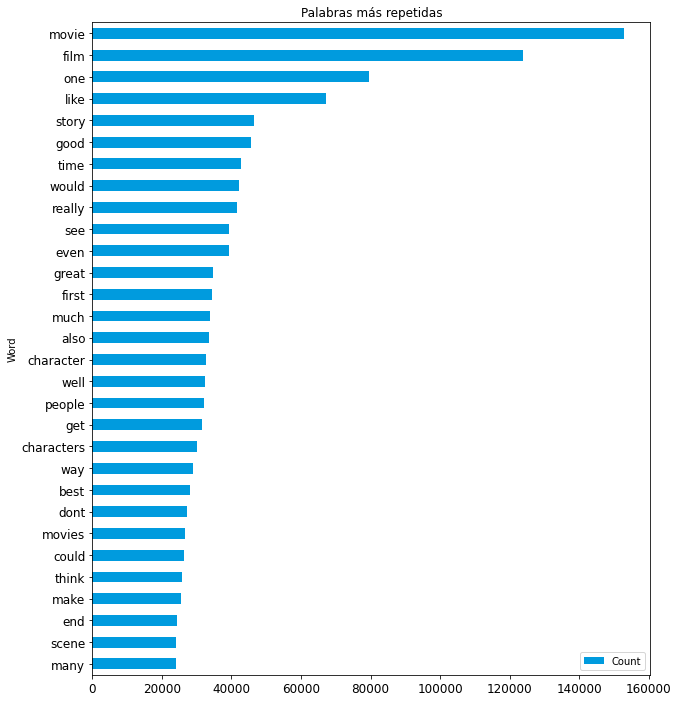

In [21]:
# Obtenemos la cantidad de repeticiones por palabras y los ordenamos para graficar
counter_root_df = pd.DataFrame.from_records(counter_root.most_common(30), columns =['Word', 'Count'])
counter_root_df = counter_root_df.sort_values('Count',ascending=True)
counter_root_df.plot.barh(x='Word', y='Count', figsize=(10,12), color="#009bde", fontsize=12).set_title("Palabras más repetidas")

Vemos que las palabras que más se repiten hacen referencia a la película en si, destacando las palabras "movie" y "film". También podemos encontrar que se encuentran varios adjetivos calificativos como ser "well", "good", "great", "best" que generalmente se usan para expresar una opinión personal, sin embargo, estas pueden llegar a tal nivel de detalle que las convierte en una reseña con spoilers.

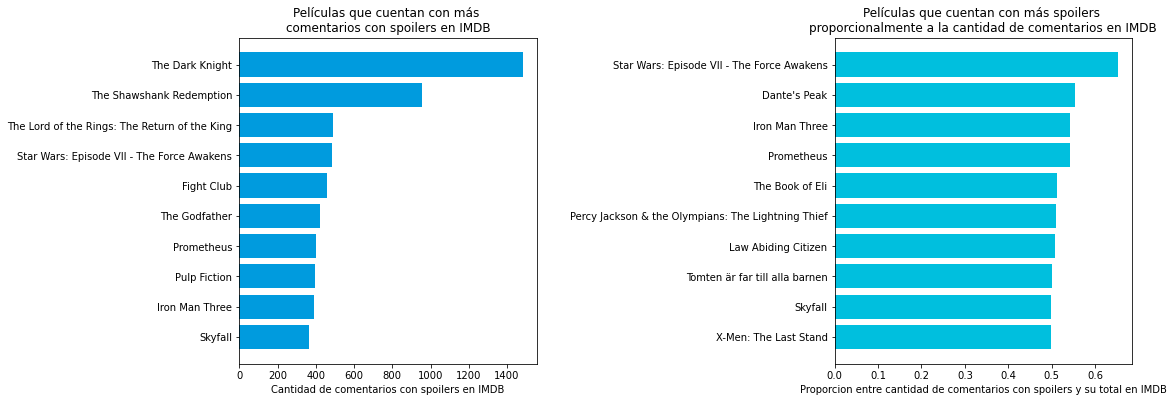

In [22]:
fig, ax = plt.subplots(1,2,figsize= (16,6))

# Obtenemos las películas con más comentarios con spoilers para graficarlos
spoiler_reviews= final_movies_data.sort_values('spoiler_reviews', ascending=False).head(10)
proportional_reviews= final_movies_data.sort_values('proportional', ascending=False).head(10)

spoiler_reviews = spoiler_reviews.iloc[::-1]
proportional_reviews = proportional_reviews.iloc[::-1]

sbplt = ax[0]
sbplt.barh(y=spoiler_reviews['original_title'], width=spoiler_reviews['spoiler_reviews'], color="#009bde")
sbplt.set_title("Películas que cuentan con más \ncomentarios con spoilers en IMDB")
sbplt.set_xlabel('Cantidad de comentarios con spoilers en IMDB')
sbplt = ax[1]
sbplt.barh(y=proportional_reviews['original_title'], width=proportional_reviews['proportional'], color="#00bfde")
sbplt.set_title("Películas que cuentan con más spoilers \nproporcionalmente a la cantidad de comentarios en IMDB")
sbplt.set_xlabel('Proporcion entre cantidad de comentarios con spoilers y su total en IMDB')
fig.subplots_adjust(wspace=1)

Previo al análisis de las películas que más spoilers presentaban, esperábamos encontrar entre los primeros lugares a películas de super héroes, ya que estas generan muchas expectativas y tanto fans como haters suelen realizar reseñas explicando a detalle porque les gustó o no les gustó la película que tanto esperaban.
Tal como lo esperábamos el primer lugar en la película con la mayor cantidad de spoilers se encuentra en la categoría previamente mencionada, y por el lado del análisis del porcentaje de las reseñas que presentan spoiler, observamos "Iron Man Three" y "X-Men: The Last Stand" se encuentran en el top 10.

In [23]:
# Obtenemos los actores presentes en las películas con más comentarios con spoilers
actor_spoilers = final_movies_data.explode('actors')[['actors', 'spoiler_reviews', 'total_reviews']].groupby('actors').sum()
actor_spoilers['proportional'] = actor_spoilers["spoiler_reviews"] / actor_spoilers["total_reviews"]

In [24]:
# Obtenemos los generos de las películas con más comentarios con spoilers
genre_spoilers = final_movies_data.explode('genre')[['genre', 'spoiler_reviews', 'total_reviews']].groupby('genre').sum()
genre_spoilers['proportional'] = genre_spoilers["spoiler_reviews"] / genre_spoilers["total_reviews"]

In [25]:
# Obtenemos los directores presentes en las películas con más comentarios con spoilers
director_spoilers = final_movies_data.explode('director')[['director', 'spoiler_reviews', 'total_reviews']].groupby('director').sum()
director_spoilers['proportional'] = director_spoilers["spoiler_reviews"] / director_spoilers["total_reviews"]

In [26]:
def plot_spoilers_vs_proportional(df, feature):
    """    
    Esta es una función para graficar 2 gráficos de barras horizontales comparativos, una gráfica representa hechos y la otra valores proporiconales

    Parameters
    ----------
    df : DataFrame, sigla que representa la moneda
        
    feature : string, Nombre del feature a comparar
    Returns
    -------
    Plot
        Se generan 2 plots que representan el top 10 del feature proporcionado con mayor cantidad de comentarios con spoilers y el top 10 del mismo feature cuyas peliculas cuentan con más spoilers proporcionalmente a la cantidad de comentarios en IMDB
        
    Examples
    --------
    >>> plot_spoilers_vs_proportional(actor_spoilers, 'Actores')
    """
    
    fig, ax = plt.subplots(1,2,figsize= (16,6))

    spoiler_reviews= df.sort_values('spoiler_reviews', ascending=False).head(10)
    proportional_reviews= df.sort_values('proportional', ascending=False).head(10)
    
    spoiler_reviews = spoiler_reviews.iloc[::-1]
    proportional_reviews = proportional_reviews.iloc[::-1]
    
    sbplt = ax[0]
    sbplt.barh(y=spoiler_reviews.index[:10], width=spoiler_reviews['spoiler_reviews'], color="#009bde")
    sbplt.set_title(f"{feature} cuyas peliculas cuentan con más \ncomentarios con spoilers en IMDB")
    sbplt.set_xlabel('Cantidad de comentarios con spoilers en IMDB')
    sbplt = ax[1]
    sbplt.barh(y=proportional_reviews.index[:10], width=proportional_reviews['proportional'], color="#00bfde")
    sbplt.set_title(f"{feature} cuyas peliculas cuentan con más \nspoilers proporcionalmente a la cantidad de comentarios en IMDB")
    sbplt.set_xlabel('Proporcion entre cantidad de comentarios con spoilers y su total en IMDB')
    fig.subplots_adjust(wspace=0.4)

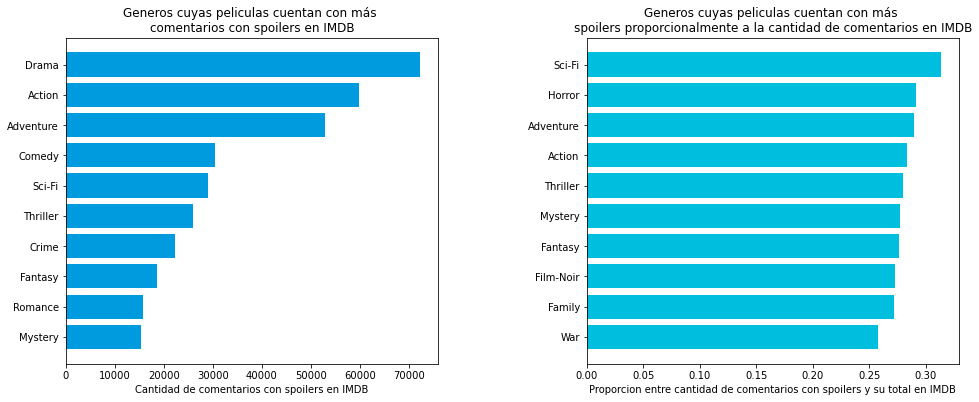

In [27]:
plot_spoilers_vs_proportional(genre_spoilers, 'Generos')

Como una hipotesis que tuvimos como equipo fue que las peliculas que más spoilers tendrían, serían del género "sci-fi", esto debido a que a través de los últimos años, lás películas que sufren mayormente de ataques de spoilers masivos son las películas de super héroes, películas que caen bajo el género previamente mencionado.
Gracias a la información generada, pudimos observar que si bien no es el género que más comentarios con spoilers contiene, es el género que más spoilers tiene en relación con la cantidad de comentarios que se publican en la plataforma de IMDb.
De 92262 comentarios, aproximadamente el 31.33 % de todos sus comentarios en la plataforma contienen spoilers. Tengan cuidado!

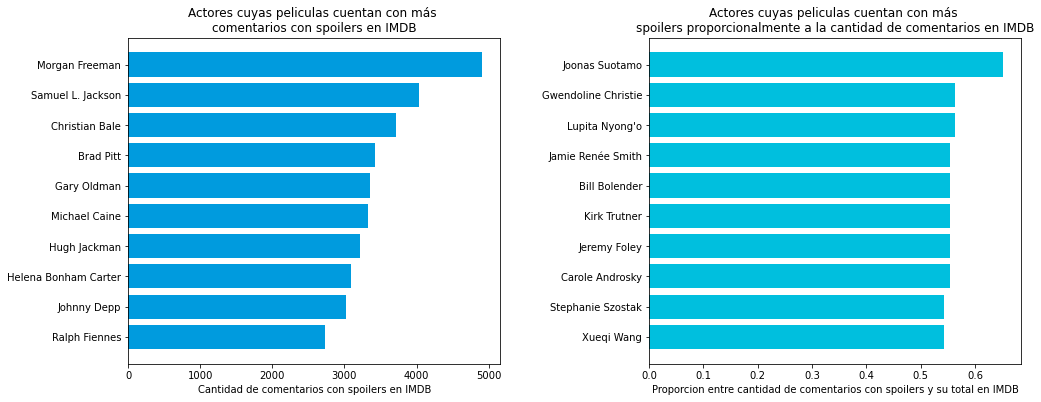

In [28]:
plot_spoilers_vs_proportional(actor_spoilers, 'Actores')

Como podemos ver los actores que salen en el top 10 son los mismos que participaron en las películas que obtuvieron más comentarios con spoilers. Analizando ambas gráficos, vemos que no se repiten ninguno de los datos entre las primeras posiciones, esto se debe a que los actores de los "spoilers proporcionales" participaron en pocas películas, sin embargo estas tuvieron un gran porcentaje de spoilers por reseña. Tal es el caso de Joonas Suotamo que encabeza esta lista al haber prestado su voz para el personaje de Chewbacca en la película de Star Wars VII. 

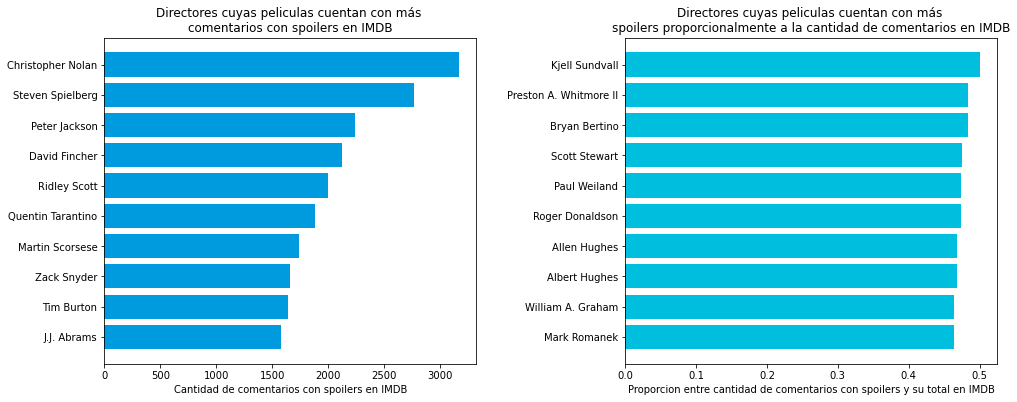

In [29]:
plot_spoilers_vs_proportional(director_spoilers, 'Directores')

Revisando los directores, notamos que al igual que los actores, destacan aquellos que dirigieron las películas que presentaron la mayor cantidad de spoilers. Por otro lado al analizar los directores presentes en las películas con mayor porcentaje de spoilers en sus reseñas, vemos que no se encuentra ninguna persona altamente reconocida en el mundo del cine, esto se debe ya que dirigieron películas que a penas obtuvieron reseñas y de las pocas recibidas un alto porcentaje tenía spoilers. Tal es el caso de Kjell Sundvall, que tiene un total de 4 reseñas de las cuales 2 son spoilers, por lo que el porcentaje calculado termina siendo un 50%. 

## 2. Modelo

In [30]:
# Vectoriamos los comentarios para obtener sus features totales
vectorizer = TfidfVectorizer()
vect = vectorizer.fit(movies_reviews_sample["review_text"])
X = vect.transform(movies_reviews_sample["review_text"])
y = movies_reviews_sample["is_spoiler"]
vectorizer.get_feature_names_out()

array(['00', '000', '0000', ..., '𝐶𝑖𝑛𝑒𝑚𝑎', '𝐻𝑢𝑔𝑜', '𝑃𝑎𝑟𝑎𝑑𝑖𝑠𝑜'],
      dtype=object)

In [31]:
# Separamos los datos para el training y testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [32]:
%%time
# Entrenamos el modelo estadístico elegido
logistic = LogisticRegressionCV(cv=10, random_state=0).fit(X_train, y_train)

Wall time: 18min 42s


In [33]:
# Obtenemos las palabras más representativas de los comentarios con spoilers
coefs=logistic.coef_[0]
top_three = np.argpartition(coefs, -20)[-20:]
print(np.array(vectorizer.get_feature_names())[top_three])

['warning' 'contain' 'mandarin' 'alert' 'end' 'scene' 'killing' 'died'
 'kill' 'kills' 'ending' 'death' 'dies' 'dir' 'example' 'die' 'twoface'
 'killed' 'spoiler' 'spoilers']


In [34]:
# Observamos la cantidad de features diferentes en nuestro dataset
X.shape

(200000, 529683)

Text(0.5, 1.0, 'Confussion Matrix')

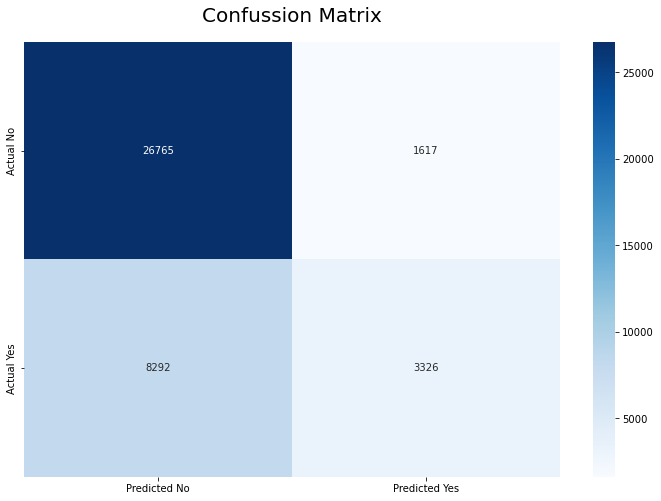

In [35]:
# Obtenemos la matriz de confusión, en base a las predicciones del modelo y los labels de testing
labels_logistic = logistic.predict(X_test)

cm = confusion_matrix(y_test, labels_logistic)
confussion_matrix = pd.DataFrame(cm, index=['Actual No', 'Actual Yes'], columns=['Predicted No', 'Predicted Yes'])
plt.figure(figsize = (12,8))
sns.heatmap(confussion_matrix, annot=True, cmap='Blues', fmt='g')
plt.title('Confussion Matrix', pad=20, fontsize=20)

In [36]:
# Verificamos que los valores que obtuvimos esten correctos, usando las librerias de sklearn
pd.DataFrame(data=[accuracy_score(y_test, labels_logistic), recall_score(y_test, labels_logistic),
                   precision_score(y_test, labels_logistic), f1_score(y_test, labels_logistic)], 
             index=["accuracy", "recall", "precision", "f1_score"], columns=["Value"])

,Value
accuracy,0.752275
recall,0.286280
precision,0.672871
f1_score,0.401667


Como podemos observar, las métricas obtenidas no son tan elevadas. Los modelos desarrollados pueden ser mejorados, empezando con usar la totalidad de los datos para el entrenamiento del mismo, ya que como se mencionó previamente, por cuestiones de tiempo no fue posible entrenar el modelo con los 573913 datos.

In [37]:
%%time
# Redimensionamos los features a 2 para poder visualizarlos
movies_reviews_reduced = TSNE(n_components=2, random_state=0).fit_transform(X)

Wall time: 41min 34s


In [38]:
%%time
# Agrupamos los comentarios en cluster
labels_kmeans = KMeans(n_clusters=2, random_state=0).fit_predict(movies_reviews_reduced)

Wall time: 757 ms


Text(0.5, 1.0, 'K-Means labels')

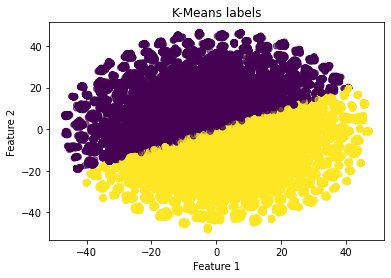

In [39]:
# Ploteamos los datos reducidos en 2 dimensiones en base a los labels de kmeans
plt.scatter(movies_reviews_reduced[:,0], movies_reviews_reduced[:,1], c=labels_kmeans, alpha=0.6)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title("K-Means labels")

Text(0.5, 1.0, 'Confussion Matrix')

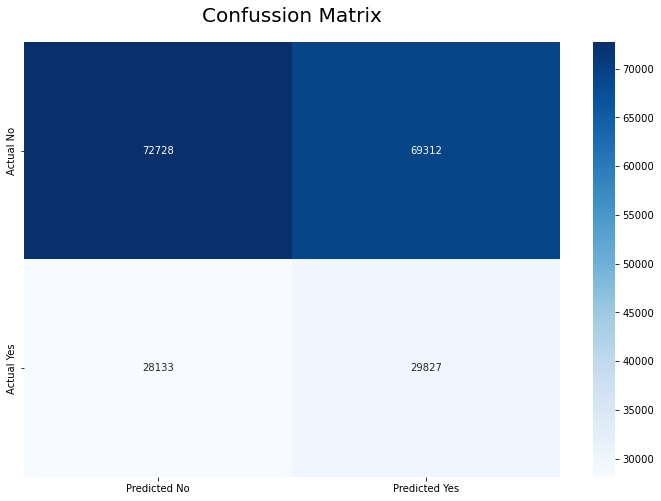

In [40]:
# Obtenemos la matriz de confusión, en base a las predicciones del modelo y los labels de testing
labels_kmeans_fix = np.where((labels_kmeans==0)|(labels_kmeans==1), labels_kmeans^1, labels_kmeans)

cm = confusion_matrix(y, labels_kmeans)
confussion_matrix = pd.DataFrame(cm, index=['Actual No', 'Actual Yes'], columns=['Predicted No', 'Predicted Yes'])
plt.figure(figsize = (12,8))
sns.heatmap(confussion_matrix, annot=True, cmap='Blues', fmt='g')
plt.title('Confussion Matrix', pad=20, fontsize=20)

In [41]:
# Verificamos que los valores que obtuvimos esten correctos, usando las librerias de sklearn
pd.DataFrame(data=[accuracy_score(y, labels_kmeans), recall_score(y, labels_kmeans),
                   precision_score(y, labels_kmeans), f1_score(y, labels_kmeans)], 
             index=["accuracy", "recall", "precision", "f1_score"], columns=["Value"])

,Value
accuracy,0.512775
recall,0.514614
precision,0.300860
f1_score,0.379722


Podemos ver que al reducir a 2 dimensiones los features solo se logra observar un solo cluster, pese a que se esperaba una clara distinción de 2 clusters (con y sin spoilers). Se considera que esto se debe a la gran reducción de features sufrida para obtener este gráfico y por ende las métricas obtenidas son bastante bajas.